In [1]:
import sys,time
sys.path.append('../')
from smodels.theory.tree import Tree, InclusiveParticleNode
from smodels.theory.auxiliaryFunctions import bracketToProcessStr,flattenArray
from smodels.experiment.defaultFinalStates import finalStates
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.tree import Tree
from smodels.theory.treeMatcher import TreeMatcher
from smodels.tools.physicsUnits import fb, GeV, TeV
from smodels.theory.element import Element
from smodels.theory.auxiliaryFunctions import (elementsInStr, removeUnits, unscaleWidth,
                                               rescaleWidth, flattenArray, reshapeList,
                                               removeInclusives, addInclusives)

import networkx as nx
import numpy as np
import unum

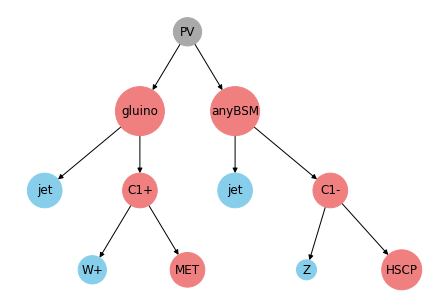

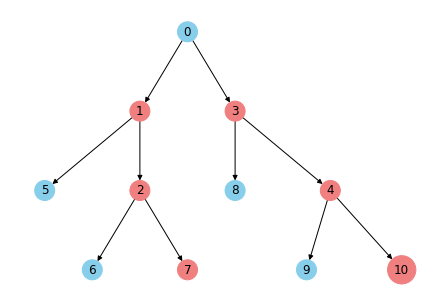

In [77]:
el = Element("[[['jet'],['W+']],[['jet'],['Z']]]",model=finalStates,sort=False,
             intermediateState=[['gluino','C1+'],['anyBSM','C1-']],finalState=['MET','HSCP'])
el.drawTree()
el.drawTree(labelAttr='node')

In [53]:
class TxDummy(object):
    
    def __init__(self,tree):
        self.dataMap = {}
        self.tree = tree

    def getDataEntry(self,arrayValue):

        mass,massUnit = None,None
        width,widthUnit = None,None
        if isinstance(arrayValue,tuple):
            mass,width = arrayValue
            massUnit = unum.Unum(mass._unit)
            widthUnit = unum.Unum(width._unit)
        elif isinstance(arrayValue,unum.Unum):
            mass = arrayValue
            massUnit = unum.Unum(mass._unit)
        else:
            logger.error("Can not convert array value %s " % (arrayValue))
            raise SModelSError()

        return mass,massUnit,width,widthUnit

    
    def formatData(self,dataPoint):
        
        if not self.dataMap:
            self.dataMap = {}
        
        


    def getDataMap(self,dataPoint):
        
#         el = self._topologyDict.getElements()[0]
#         tree = el.tree
        tree = self.tree


        dataMap = {}
        arrayMap = {}
        # Remove inclusive tags:
        dataPoint = [d for d in dataPoint[:] if d != '*' and d != ['*']]
        # Flatten array to 1D
        dataPointFlat = np.array(dataPoint,dtype=object).flatten()

        massIndex = 0 # Initial index for the masses
        widthIndex = len(dataPointFlat) # Initial index for the widths
        for mom,daughters in tree.dfs_successors().items():
            if mom == tree.root: # Ignore PV
                continue        
            arrayValue = dataPointFlat[massIndex]
            mass,massUnit,width,widthUnit = self.getDataEntry(arrayValue)
            # Add entry for mass
            if mass is not None:
                dataMap[massIndex] = (mom.node,'mass',massUnit) 
                massIndex += 1
            # Add entry for width
            if width is not None:
                dataMap[widthIndex] = (mom.node,'totalwidth',widthUnit)
                widthIndex += 1

            for d in daughters:
                if d.isInclusive: # Ignore inclusive nodes
                    continue
                if d.isSM: #  Ignore SM particles
                    continue
                if tree.out_degree(d) != 0: # Ignore unstable daughters (will appear as mom)
                    continue

                arrayValue = dataPointFlat[massIndex]
                mass,massUnit,width,widthUnit = self.getDataEntry(arrayValue)
                # Add entry for mass
                if mass is not None:
                    dataMap[massIndex] = (d.node,'mass',massUnit) 
                    massIndex += 1
                # Add entry for width
                if width is not None:
                    dataMap[widthIndex] = (d.node,'totalwidth',widthUnit)
                    widthIndex += 1

        return dataMap


    def getDataFromElement(self,element):
        
        dataMap = self.dataMap
        elementData = [None]*(1+max(dataMap.keys()))
        for indexArray,nodeTuple in dataMap.items():
            nodeNumber,attr,unit  = nodeTuple
            node = element.tree.getNode(nodeNumber)
            value = getattr(node,attr)
            if isinstance(unit,unum.Unum):
                value = value.asNumber(unit)        
            if attr == 'totalwidth':
                value = rescaleWidth(value)
            elementData[indexArray] = value
        
        return elementData
        

In [81]:
massPoint = np.array([[100*TeV,51*GeV,(5*GeV,1e-3*GeV)],[110*GeV,(50*GeV,1e-6*GeV),10*GeV]],dtype=object)
tree = el.tree

# Get a nested array of nodes corresponding to the data point:
nodeArray = []
for mom,daughters in tree.dfs_successors().items():
    if mom == tree.root: # Ignore PV
        continue        
    nodeArray.append(mom)
    for d in daughters:
        if d.isSM: #  Ignore SM particles
            continue
        if tree.out_degree(d) != 0: # Ignore unstable daughters (will appear as mom)
            continue
        nodeArray.append(d)

try:        
    nodeArray = np.reshape(nodeArray,massPoint.shape)
except ValueError:
    logger.error("Error matching Txname element to data grid:\n %s\n and %s" %(nodeArray,massPoint))
    raise SModelSError()

    
# Iterate over the array and construct a map for the nodes
# and the flat array:
iterator = np.nditer(nodeArray,flags=['refs_ok','multi_index'],order='K')
massMap = {}
widthMap = {}
massIndex = 0 # Initial index for the masses
widthIndex = 0 # Initial index for the widths
for node in iterator:
    node.isInclusive:
        continue
    arrayValue = massPoint[iterator.multi_indes]
    mass,massUnit,width,widthUnit = self.getDataEntry(arrayValue)
    # Add entry for mass
    if mass is not None:
        massMap[massIndex] = (node.node,'mass',massUnit) 
        massIndex += 1
    # Add entry for width
    if width is not None:
        widthMap[widthIndex] = (node.node,'totalwidth',widthUnit)
        widthIndex += 1
    # Add entry for nested array map:
    arrayMap[]
    

[[gluino C1+ MET]
 [anyBSM C1- HSCP]]


In [66]:
x = np.array([[100*GeV,50*GeV]]*2,dtype=object)
shape = x.shape
y = x.flatten()
yIndices = list(range(4))
np.reshape(yIndices,shape)

array([[0, 1],
       [2, 3]])

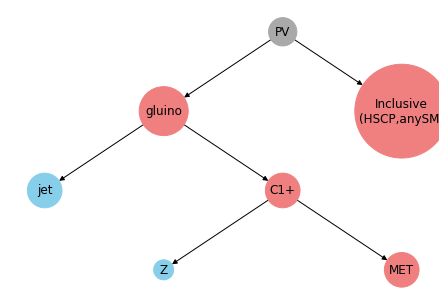

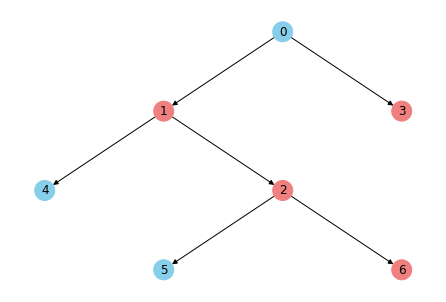

In [56]:
elInc = Element("[[['jet'],['Z']],['*']]",model=finalStates,sort=False,
             intermediateState=[['gluino','C1+'],['anyBSM','C1-']],finalState=['MET','HSCP'])
elInc.drawTree()
elInc.drawTree(labelAttr='node')

In [57]:
tx = TxDummy(elInc.tree)
dataPoint = [['*'],[100*GeV,(50*GeV,1e-3*GeV),10*GeV]]
tx.dataMap = tx.getDataMap(dataPoint)
print(tx.dataMap)
# elData = tx.getDataFromElement(elMatch)
# print(elData)

{0: (1, 'mass', 1.00E+00 [GeV]), 1: (2, 'mass', 1.00E+00 [GeV]), 3: (2, 'totalwidth', 1.00E+00 [GeV]), 2: (6, 'mass', 1.00E+00 [GeV])}


In [22]:
slhafile="../inputFiles/slha/lightEWinos.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)

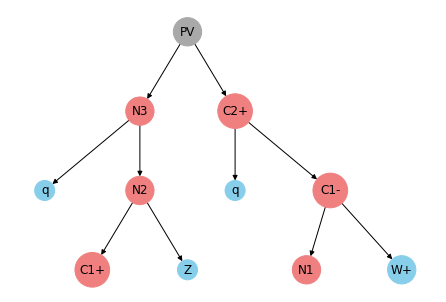

[(PV, 0), (N3, 1), (C2+, 2), (q, 3), (N2, 4), (q, 5), (C1-, 6), (C1+, 7), (Z, 8), (N1, 9), (W+, 10)]


In [23]:
elB = Element("[[['u'],['W+']],[['u'],['Z']]]",model=model,
             intermediateState=[['C2+','C1-'],['N3','N2']],finalState=['N1','C1+'])
elB.drawTree()
# elB.drawTree(labelAttr='node')
print([(n,n.node) for n in elB.tree.nodes])

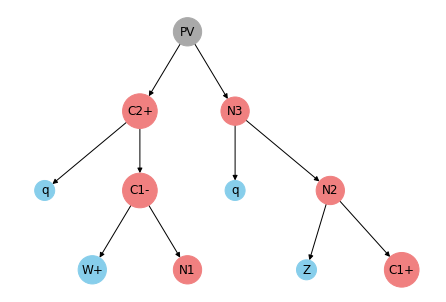

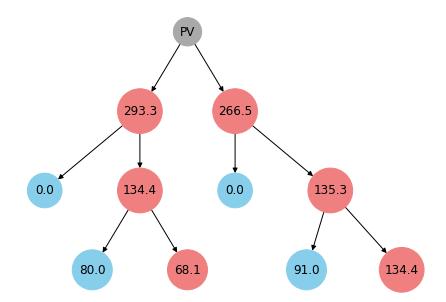

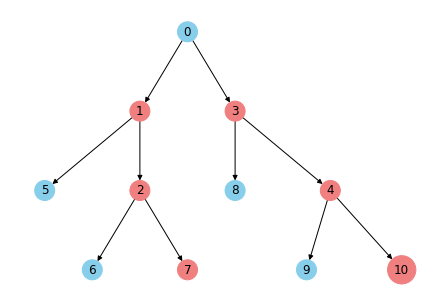

[(PV, 0), (C2+, 1), (N3, 3), (q, 5), (C1-, 2), (W+, 6), (N1, 7), (q, 8), (N2, 4), (Z, 9), (C1+, 10)]


In [24]:
cmp,elMatch = el.compareTo(elB)
elMatch.drawTree()
elMatch.drawTree(labelAttr='mass',attrUnit=GeV)
elMatch.drawTree(labelAttr='node')
print([(n,n.node) for n in elMatch.tree.nodes])

In [26]:
tree = el.tree
dataPoint = [[200*GeV,150*GeV,(100*GeV,1e-6*GeV)]]*2

In [27]:
tx = TxDummy(tree)
tx.dataMap = tx.getDataMap(dataPoint)
elData = tx.getDataFromElement(elMatch)
print(elData)

[293.3, 134.4, 68.1, 266.5, 135.3, 134.4, 0.0, 184.20680743952366]


In [28]:
tx = TxDummy(tree)
dataPoint = [['*'],[100*GeV,(50*GeV,1e-3*GeV)]]
tx.dataMap = tx.getDataMap(dataPoint)
print(tx.dataMap)
# elData = tx.getDataFromElement(elMatch)
# print(elData)

{}


In [29]:
elData = [None]*(1+max(dataMap.keys()))
for indexArray,nodeTuple in dataMap.items():
    nodeNumber,attr,unit  = nodeTuple
    node = elMatch.tree.getNode(nodeNumber)
    value = getattr(node,attr)
    if isinstance(unit,unum.Unum):
        value = value.asNumber(unit)        
    if attr == 'totalwidth':
        value = rescaleWidth(value)
    elData[indexArray] = value
print(elData)

[293.3, 134.4, 68.1, 266.5, 135.3, 134.4, 0.0, 184.20680743952366]


In [ ]:
dataMap

In [ ]:
elMatch.tree.node

In [ ]:

def dataToCoordinates(self, dataPoint, rotMatrix=None,
                      transVector=None):
    """
    Format a dataPoint to the format used for interpolation.
    All the units are removed, the widths are rescaled and the masses
    and widths are combined in a flat array.
    The input can be an Element object or a massAndWidth nested arrays
    (with tuples to store the relevant widths).

    :param dataPoint: Element object from which the mass and width arrays will be extracted or
                      a nested mass array from the database, which contain tuples to include
                      the width values

    :param rotMatrix: Rotation matrix for PCA (e.g. self._V).
                      If None, no rotation is performed.
    :param transVector: Translation vector for PCA (e.g. self.delta_x).
                        If None no translation is performed

    :return: Point (list of floats)
    """

    # Collect the data
    if isinstance(dataPoint, Element):
        masses = dataPoint.mass
        widths = dataPoint.totalwidth
    elif isinstance(dataPoint, list):
        masses = [[mw[0] if isinstance(mw, tuple) else mw for mw in br] for br in dataPoint]
        widths = [[mw[1] if isinstance(mw, tuple) else None for mw in br] for br in dataPoint]
    else:
        logger.error("dataPoint must be an element or a nested array including masses and widths")
        raise SModelSError()

    # Select the required masses (remove entries corresponding to inclusive entries in data)
    masses = removeInclusives(masses, self.dataShape)
    # Select the required widths (remove widths not used in interpolation)
    widths = [[widths[ibr][im] for im, _ in enumerate(br)
               if (ibr, im) in self.widthPosition]
              for ibr, br in enumerate(widths)]
    if None in removeUnits(flattenArray(widths), GeV):
        logger.error("Error obtaining widths from %s" % str(dataPoint))
        raise SModelSError()

    # Remove units and flatten arrays:
    masses = flattenArray(masses)
    masses = removeUnits(masses, physicsUnits.standardUnits)
    widths = flattenArray(widths)
    widths = removeUnits(widths, physicsUnits.standardUnits)
    # Rescale widths:
    xwidths = [rescaleWidth(w) for w in widths]

    # Combine masses and rescaled widths in a single point
    point = masses + xwidths

    # Now transform to PCA coordinates (if rotMatrix and transVector are defined:
    if transVector is not None:
        point = np.array([point])
        point = ((point - transVector)).tolist()[0]  # Translate
    if rotMatrix is not None:
        point = np.dot(point, rotMatrix)  # Rotate
        point = point.tolist()

    return point

def coordinatesToData(self, point, rotMatrix=None, transVector=None):
    """
    A function that return the original mass and width array (including the widths
    as tuples) for a given point in PCA space (inverse of dataToCoordinates).

    :param point: Point in PCA space (1D list with size equal
                  to self.full_dimensionality or self.dimensionality)

    :param rotMatrix: Rotation matrix for PCA (e.g. self._V).
                      If None, no rotation is performed.
    :param transVector: Translation vector for PCA (e.g. self.delta_x).
                        If None no translation is performed

    :return: nested mass array including the widths as tuples (e.g. [[(200,1e-10),100],[(200,1e-10),100]])
    """

    if len(point) != self.full_dimensionality and len(point) != self.dimensionality:
        logger.error("Wrong point dimensions (%i), it should be %i (reduced dimensions) or %i (full dimensionts)"
                     % (len(point), self.dimensionality, self.full_dimensionality))
    elif len(point) != self.full_dimensionality:
        pointFull = np.array(point[:])
        pointFull = np.append(pointFull, [0.]*(self.full_dimensionality-len(point)))
    else:
        pointFull = np.array(point[:])

    massAndWidths = pointFull
    if rotMatrix is not None:
        massAndWidths = np.dot(rotMatrix, massAndWidths)
    if transVector is not None:
        massAndWidths = massAndWidths + transVector

    massAndWidths = massAndWidths.tolist()
    if type(massAndWidths[0]) == list:
        massAndWidths = massAndWidths[0]
    # Extract masses and transformed widths
    masses = massAndWidths[:len(massAndWidths)-len(self.widthPosition)]
    xwidths = massAndWidths[len(massAndWidths)-len(self.widthPosition):]
    # Rescale widths and add unit:
    widths = [unscaleWidth(xw) for xw in xwidths]
    # Add units (make sure it is consistent with standardUnits)
    massUnit = [unit for unit in physicsUnits.standardUnits
                if not (1*GeV/unit).normalize()._unit][0]
    masses = [m*massUnit for m in masses[:]]
    # Add inclusive entries to mass
    flatShape = flattenArray(self.dataShape)
    if len([x for x in flatShape if str(x) != '*']) != len(masses):
        logger.error("Error trying to add inclusive entries (%s) to flat mass array (%s)."
                     % (flatShape, masses))
        raise SModelSError()
    masses = addInclusives(masses, flatShape)
    # Reshape masses according to dataShape:
    if len(masses) != len(flatShape):
        logger.error("Number of elements in %s do not match the number of entries in %s"
                     % (masses, self.dataShape))
        raise SModelSError()

    massArray = reshapeList(masses, self.dataShape)
    # Add widths to the mass array
    if len(widths) != len(self.widthPosition):
        logger.error("The number of converted widths (%i) is not the expected (%i)"
                     % (len(widths), len(self.widthPosition)))
        raise SModelSError()

    # Combine masses and widths
    massAndWidthArray = []
    for ibr, br in enumerate(massArray):
        if str(br) != '*':
            newBr = [(m, widths.pop(0)) if (ibr, im) in self.widthPosition else m
                     for im, m in enumerate(br)]
        else:
            newBr = br
        massAndWidthArray.append(newBr)

    return massAndWidthArray



def getUnits(self, value):
    """
    Get standard units for the input object.
    Uses the units defined in physicsUnits.standardUnits.
    (e.g. [[100*GeV,100.*GeV],3.*pb] -> returns [[GeV,GeV],fb]
    [[100*GeV,3.],[200.*GeV,2.*pb]] -> returns [[GeV,1.],[GeV,fb]] )

    :param value: Object containing units (e.g. [[100*GeV,100.*GeV],3.*pb])

    :return: Object with same structure containing the standard units used to
             normalize the data.
    """

    stdUnits = physicsUnits.standardUnits
    if isinstance(value, list):
        return [self.getUnits(x) for x in value]
    if isinstance(value, tuple):
        return tuple([self.getUnits(x) for x in value])
    elif isinstance(value, dict):
        return dict([[self.getUnits(x), self.getUnits(y)]
                     for x, y in value.items()])
    elif isinstance(value, unum.Unum):
        # Check if value has unit or not:
        if not value._unit:
            return 1.
        # Now try to find standard unit which matches:
        for unit in stdUnits:
            y = (value/unit).normalize()
            if not y._unit:
                return unit
        raise SModelSError("Could not find standard unit which matches %s. Using the standard units: %s"
                           % (str(value), str(stdUnits)))
    else:
        return 1.

def getDataShape(self, value):
    """
    Stores the data format (mass shape) and store it for future use.
    If there are inclusive objects (mass or branch = None), store their positions.

    :param value: list of data points
    """

    if isinstance(value, list):
        return [self.getDataShape(m) for m in value]
    elif isinstance(value, (float, int, unum.Unum, tuple)):
        return type(value)
    else:
        return value

def getWidthPosition(self, value):
    """
    Gets the positions of the widths to be used for interpolation.

    :param value: data point

    :return: A list with the position of the widths. A position is a tuple
             of the form (branch-index,vertex-index).
    """

    widthPositions = [(ibr, im) for ibr, br in enumerate(value) for im, m in enumerate(br)
                      if isinstance(m, tuple)]

    return widthPositions
